In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import gzip
import os
import pickle

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.misc import imread

from common import * 
import preprocess
import model_io

# Base Model

The full inception model is too slow for real time use on my laptop, so I am just using the first few layers.

Loading the whole inception model is also very slow, so cut out only the weights we need and save them for loading later.

In [ ]:
import inception
import model_io

model_io.save_model(
    BASE_MODEL_JSON_FILE,
    BASE_MODEL_WEIGHTS_FILE,
    inception.make_cut_model())

In [ ]:
model_io.load_base_model().summary()

# Preprocessing

- Correct the image file paths, since I have several driving logs in different folders.
- Smooth the control inputs. The input from me is quite spikey, because all I can do is press a button or not. This seems like it would make learning quite difficult, so apply smoothing.
- Bottleneck the features to make training reasonably fast.

In [39]:
log = pd.concat([
    preprocess.run('data/ccw_short_1'),
    preprocess.run('data/cw_short_1')
])
print(log.head())

Bottleneck folder exists in data/ccw_short_1 ; just binding.
Bottleneck folder exists in data/cw_short_1 ; just binding.
                                        center_image  \
0  data/ccw_short_1/IMG/center_2016_12_09_18_59_3...   
1  data/ccw_short_1/IMG/center_2016_12_09_18_59_3...   
2  data/ccw_short_1/IMG/center_2016_12_09_18_59_3...   
3  data/ccw_short_1/IMG/center_2016_12_09_18_59_3...   
4  data/ccw_short_1/IMG/center_2016_12_09_18_59_3...   

                                          left_image  \
0  data/ccw_short_1/IMG/left_2016_12_09_18_59_34_...   
1  data/ccw_short_1/IMG/left_2016_12_09_18_59_34_...   
2  data/ccw_short_1/IMG/left_2016_12_09_18_59_34_...   
3  data/ccw_short_1/IMG/left_2016_12_09_18_59_34_...   
4  data/ccw_short_1/IMG/left_2016_12_09_18_59_34_...   

                                         right_image  steering_angle  \
0  data/ccw_short_1/IMG/right_2016_12_09_18_59_34...             0.0   
1  data/ccw_short_1/IMG/right_2016_12_09_18_59_34...         

## Smoothing

I tried two types of smoothing:

- Exponential smoothing: an exponential weighted moving average
- Gaussian smoothing: a 1D gaussian filter

Both seem to track pretty well, but the gaussian smoothing is better at preserving the mean steering angle.

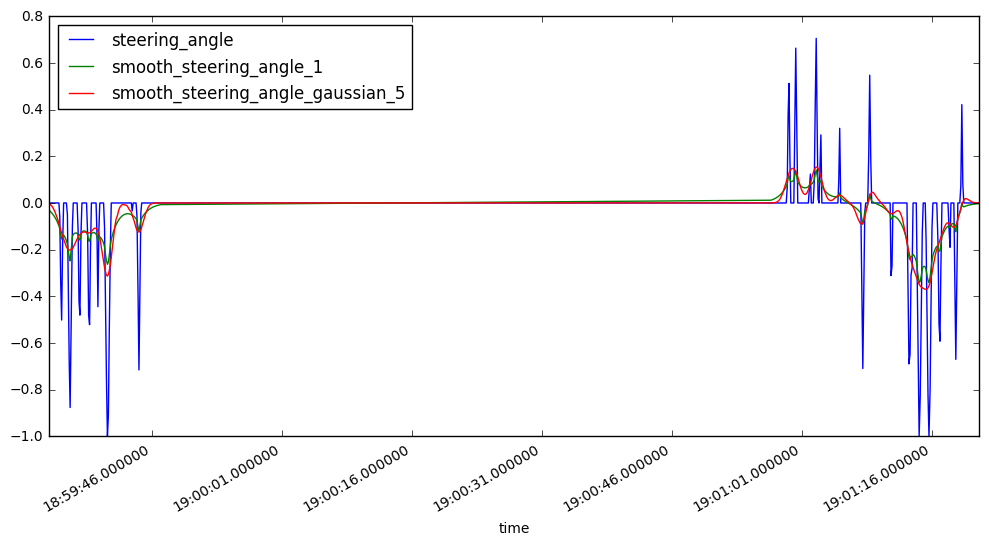

In [40]:
def plot_smooth_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1', 'smooth_steering_angle_gaussian_5']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_smooth_steering_angle()

## Steering Angle Bias

We don't want a lot of bias in the training data. Or maybe this isn't that important... I don't really know.

In [41]:
print('raw steering angle bias:', np.mean(log['steering_angle']))
print('exponentially smoothed steering angle bias:', np.mean(log['smooth_steering_angle_1']))
print('gaussian smoothed steering angle bias:', np.mean(log['smooth_steering_angle_gaussian_5']))

raw steering angle bias: -0.061706353658536606
exponentially smoothed steering angle bias: -0.061293558958787506
gaussian smoothed steering angle bias: -0.061706353658536606


## Bottleneck Features

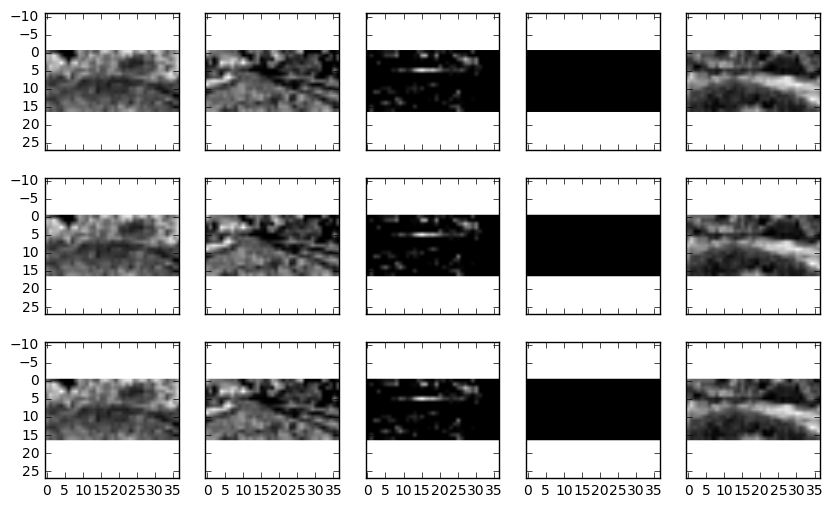

In [42]:
def plot_bottleneck_output(num_images, num_channels, image_stride=50):
    fig, axes = plt.subplots(num_images, num_channels,
                             figsize=(2*num_channels, 2*num_images),
                             sharex=True, sharey=True)
    for i in range(num_images):
        for j in range(num_channels):
            index = i * image_stride
            image = np.load(log['bottleneck_features'].values[i])['center_image']
            axes[i][j].imshow(image[:,:,j], cmap='gray')
plot_bottleneck_output(3,5)

## Smoothed Steering Video

In [46]:
def steering_angle_to_radians(steering_angle):
    """
    The recorded steering angle ranges from -1 to 1.
    In the sim, it gives values from -20 degrees to 20 degrees.
    """
    return math.radians(steering_angle * 20.0)

def draw_steering_angle(image, steering_angle, color, thickness=2):
    bottom_x = image.shape[1] / 2.0
    bottom_y = image.shape[0]
    radius = bottom_y / 2.0
    steering_angle_radians = steering_angle_to_radians(steering_angle)
    top_x = bottom_x + radius * math.sin(steering_angle_radians)
    top_y = bottom_y - radius * math.cos(steering_angle_radians)
    bottom_x, bottom_y = int(round(bottom_x)), int(round(bottom_y))
    top_x, top_y = int(round(top_x)), int(round(top_y))
    cv2.line(image, (bottom_x, bottom_y), (top_x, top_y), color, thickness)

def make_steering_movie(
    filename,
    log,
    smoothed_steering_angle_column,
    predicted_steering_angle_column=None):
    
    input_color = [0, 0, 255]
    smoothed_color = [0, 255, 0]
    predicted_color = [255, 0, 0]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # at least for Mac
    video = cv2.VideoWriter(filename, fourcc, 10, IMAGE_SHAPE[0:2][::-1])
    for i in range(len(log)):
        if i % 50 == 0:
            print('frame', i)
        image = imread(log['center_image'].values[i])
        steering_angle = log['steering_angle'].values[i]
        draw_steering_angle(image, steering_angle, input_color)

        smoothed_steering_angle = log[smoothed_steering_angle_column].values[i]
        draw_steering_angle(image, smoothed_steering_angle, smoothed_color)
        
        if predicted_steering_angle_column is not None:
            predicted_steering_angle = log[predicted_steering_angle_column].values[i]
            draw_steering_angle(image, predicted_steering_angle, predicted_color)
            
        video.write(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    video.release()

make_steering_movie('test.mp4', log[0:200], 'smooth_steering_angle_1')

frame 0
frame 50
frame 100
frame 150


# Model

In [7]:
import model

In [49]:
steering_model = model.build(
    input_shape=np.load(log['bottleneck_features'].values[0])['center_image'].shape
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 17, 37, 64)    16448       convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 40256)         0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1)             40257       flatten_3[0][0]                  
Total params: 56705
____________________________________________________________________________________________________


In [63]:
model.train(steering_model, log, nb_epoch=20, side_camera_bias=0.05)

Epoch 1/20
786/786 [==============================] - 6s - loss: 0.0168 - val_loss: 0.0024
Epoch 2/20
786/786 [==============================] - 5s - loss: 0.0151 - val_loss: 0.0024
Epoch 3/20
786/786 [==============================] - 5s - loss: 0.0146 - val_loss: 0.0021
Epoch 4/20
786/786 [==============================] - 5s - loss: 0.0139 - val_loss: 0.0021
Epoch 5/20
786/786 [==============================] - 5s - loss: 0.0136 - val_loss: 0.0019
Epoch 6/20
786/786 [==============================] - 5s - loss: 0.0132 - val_loss: 0.0019
Epoch 7/20
786/786 [==============================] - 5s - loss: 0.0129 - val_loss: 0.0018
Epoch 8/20
786/786 [==============================] - 5s - loss: 0.0127 - val_loss: 0.0018
Epoch 9/20
786/786 [==============================] - 5s - loss: 0.0124 - val_loss: 0.0018
Epoch 10/20
786/786 [==============================] - 5s - loss: 0.0122 - val_loss: 0.0017
Epoch 11/20
786/786 [==============================] - 5s - loss: 0.0120 - val_loss: 0.00

In [61]:
model_io.save_model('model.json', 'model.h5', steering_model)

In [59]:
log['predicted_steering_angle'] = steering_model.predict_generator(
    model.generate_data(log, np.arange(len(log))),
    val_samples=len(log)
).flatten()

In [ ]:
make_steering_movie('test.mp4', log[0:500], 'smooth_steering_angle_1', 'predicted_steering_angle')

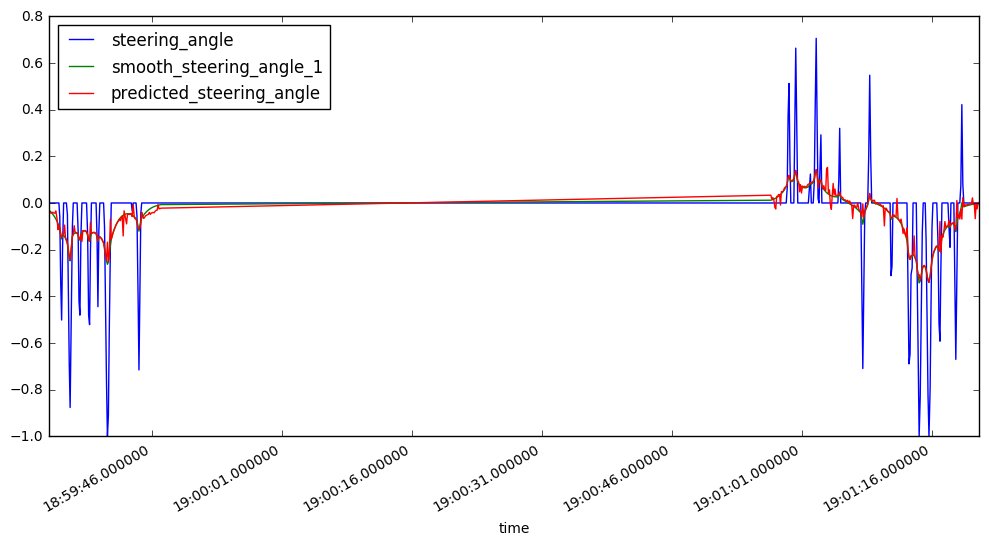

In [64]:
def plot_predicted_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1', 'predicted_steering_angle']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_predicted_steering_angle()

TODO

- capture cw_2 and ccw_2 and combine those, too